# Random Forest analysis of bike data from kaggle

In this notebook I am fitting a random forest model to the bike data from this popular kaggle data set
https://www.kaggle.com/c/bike-sharing-demand . The data is bike rental counts over time for both registered and casual users, a variety of weather data and whether it's a working day or a holiday.

First, I will look at the data and adjust the features as needed, explaining as I go. Next I will perform a random forest model on the unadjusted data and discuss the results. Then I'll also look at the data I adjusted based on the longitudinal analysis of the seasonality and trend.The following are the variables provided in the csv files:

datetime:   date and hour in "mm/dd/yyyy hh:mm" format

season:     Four categories-> 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday:    whether the day is a holiday or not (1/0)

workingday: whether the day is neither a weekend nor holiday (1/0)

weather:    Four Categories of weather

1. Clear, Few clouds, Partly cloudy, Partly cloudy

2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3. Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp:       hourly temperature in Celsius

atemp:      "feels like" temperature in Celsius

humidity:   relative humidity

windspeed:  wind speed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

import the csv file and look at the variables. Note there are no NAs

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv('Bike_train.csv', parse_dates=['datetime'], index_col='datetime',date_parser=dateparse)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB
None


add columns for hour, month and day of week

In [3]:
data['Hour'] = data.index.hour
data['Month'] = data.index.month
data['day of week'] = data.index.dayofweek

print(data.head())
print('\n')
print(data.info())

                     season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  count  Hour  \
datetime                                                                    
2011-01-01 00:00:00        81        0.0       3          13     16     0   
2011-01-01 01:00:00        80        0.0       8          32     40     1   
2011-01-01 02:00:00        80        0.0       5          27     32     2   
2011-01-01 03:00:00        75        0.0       3          10     13     3   
2011-01-01 0

casual + registered = count 

I suspect that the behavior of casual users is different from the behavior of registered users. We should look into that.


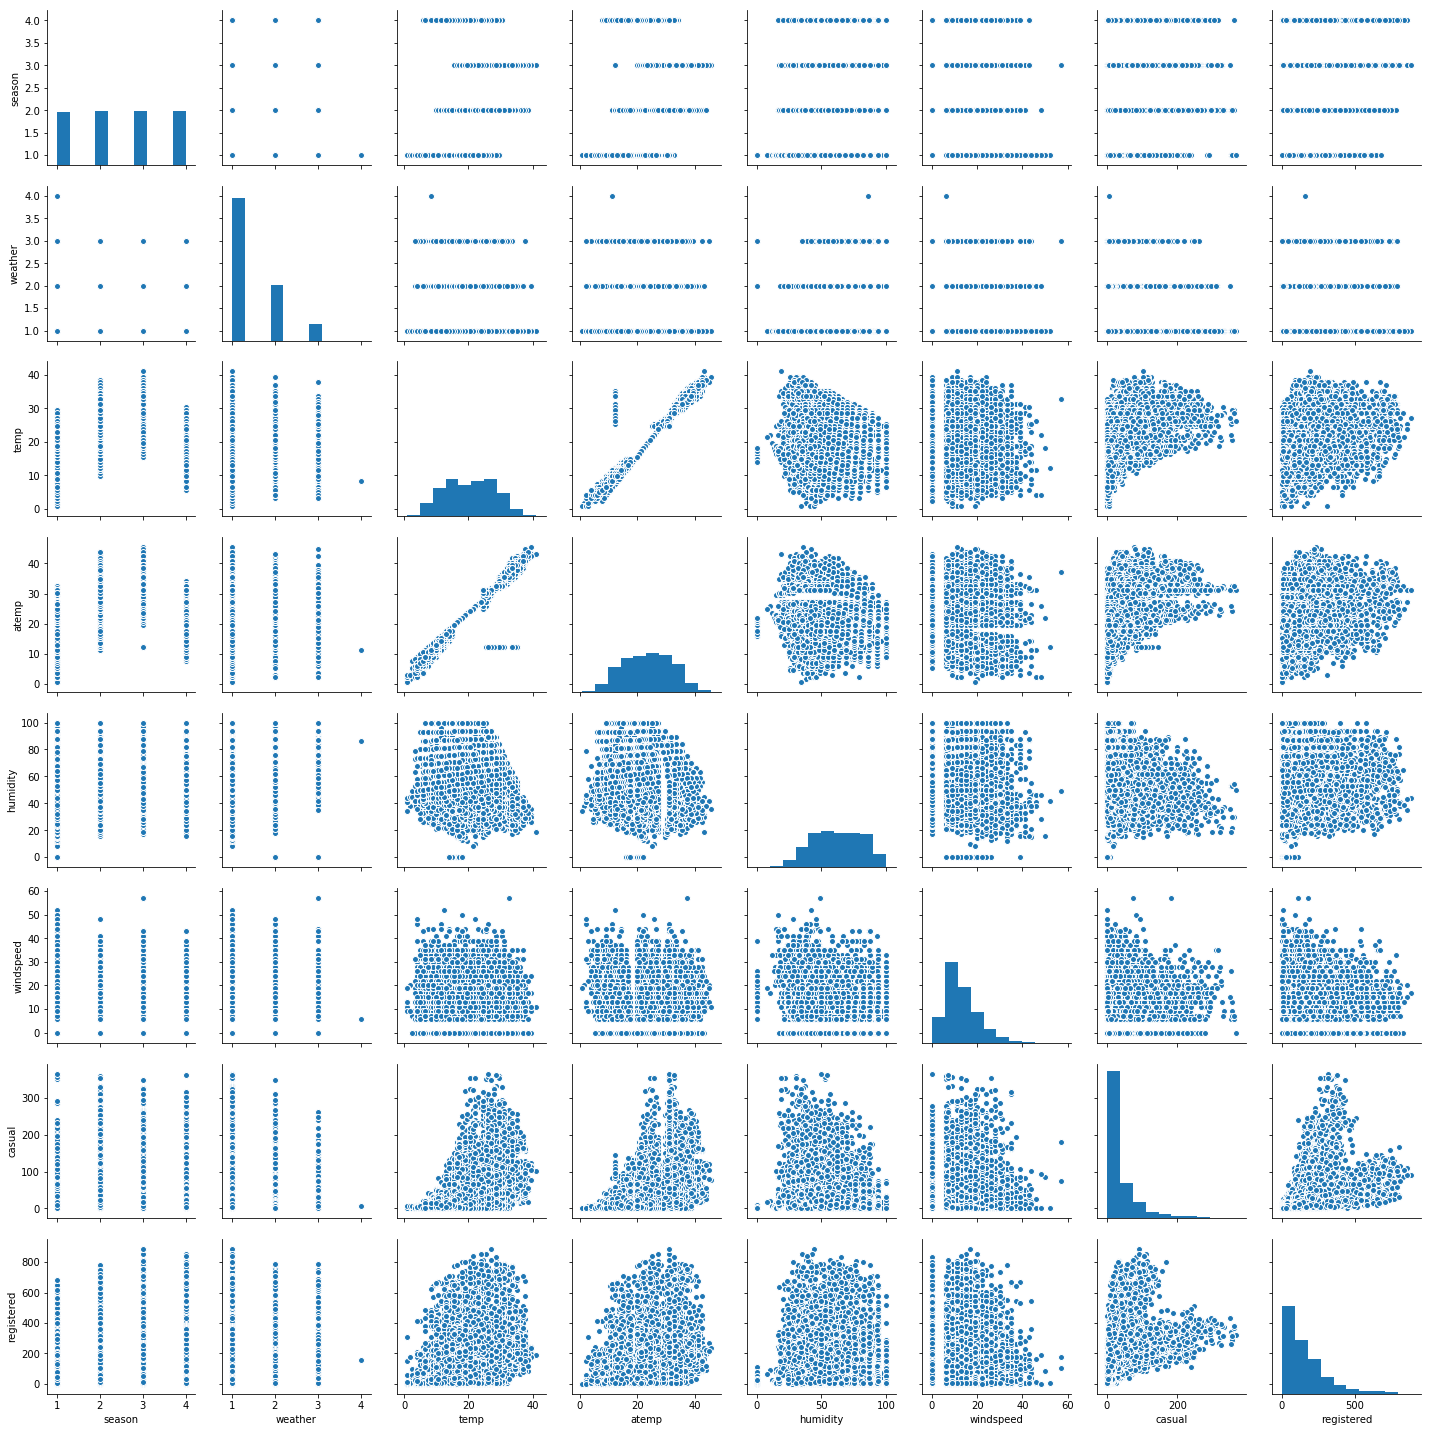

In [4]:
sns.pairplot(data.drop(['holiday','workingday','count','Hour','Month','day of week'],axis=1),)


here we see that both the windspeed and the humidity have odd zeros that are discontinuous with the rest of the distribution. I may need to impute these, since the humidity is never zero and the windspeed zero values are evenly distributed across other weather variables. Next we see that nothing is very correlated with either casual or registered use. Let's now get the seasonal and trend adjusted data from the last notebook and see if they are correlated with anything.

It turns out that the humidity is zero for one day in March 2011, which appears to be an error, so I will back fill it, but none of the test data have this problem, so it probably doesn't make much of a difference. 

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
data_reg = pd.read_csv('registered_stationary.csv', parse_dates=['datetime'], index_col='datetime',date_parser=dateparse)
data_cas = pd.read_csv('casual_stationary.csv', parse_dates=['datetime'], index_col='datetime',date_parser=dateparse)

print(data_reg.info())
print(data_cas.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 4 columns):
data        10886 non-null int64
trend       10886 non-null float64
seasonal    10886 non-null float64
residual    10886 non-null float64
dtypes: float64(3), int64(1)
memory usage: 425.2 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 4 columns):
data        10886 non-null int64
trend       10886 non-null float64
seasonal    10886 non-null float64
residual    10886 non-null float64
dtypes: float64(3), int64(1)
memory usage: 425.2 KB
None


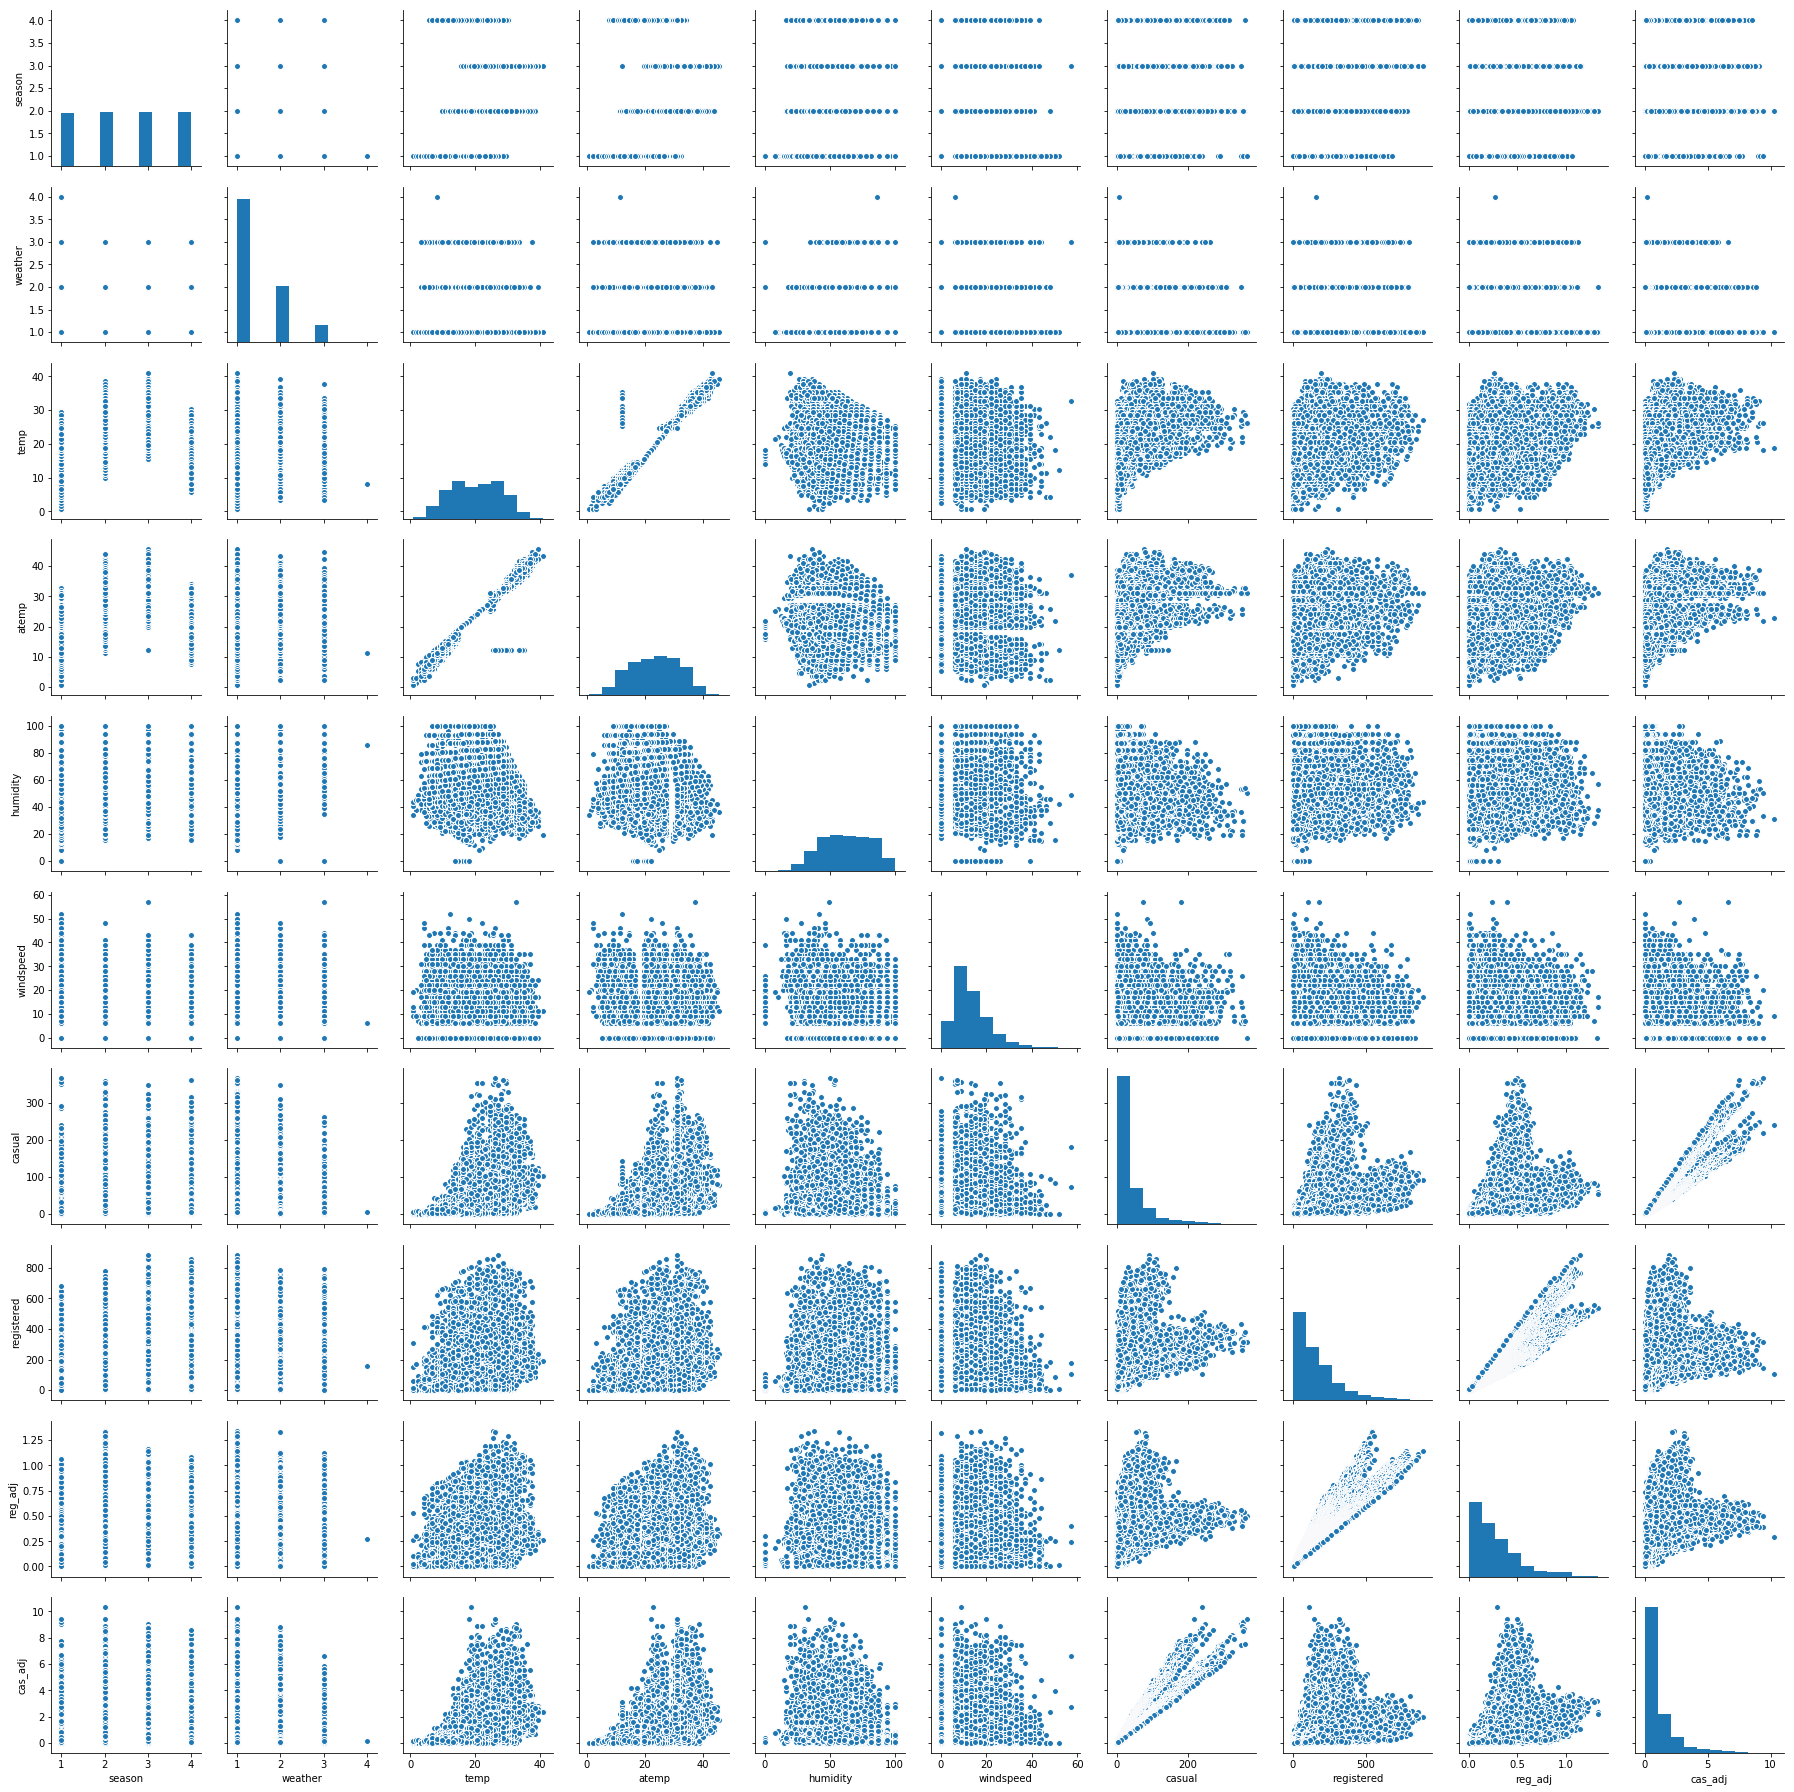

In [6]:
data['reg_adj'] = data_reg['data']/data_reg['trend']
data['cas_adj'] = data_cas['data']/data_cas['trend']
data['reg_trend'] = data_reg['trend']
data['cas_trend'] = data_cas['trend']
sns.pairplot(data.drop(['holiday','workingday','count','Hour','Month','day of week','cas_trend','reg_trend'],axis=1),)

Now I'm going to import the test data so I can assess imputing the windspeed and humidity

In [7]:
data_test = pd.read_csv('Bike_test.csv', parse_dates=['datetime'], index_col='datetime',date_parser=dateparse)
print(data_test.info())
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 8 columns):
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5)
memory usage: 456.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 18 columns):
season         10886 non-null int64
holiday        10886 non-null int64
workingday     10886 non-null int64
weather        10886 non-null int64
temp           10886 non-null float64
atemp          10886 non-null float64
humidity       10886 non-null int64
windspeed      10886 non-null float64
casual         10886 non-null int64
registered     10886 non-null int64
count        

In [8]:
data_features=data.drop(['casual','registered','count','Hour','Month','day of week','reg_adj','cas_adj'],axis=1)

In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 8 columns):
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5)
memory usage: 456.5 KB


In [10]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 10 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
reg_trend     10886 non-null float64
cas_trend     10886 non-null float64
dtypes: float64(5), int64(5)
memory usage: 1.2 MB


In [12]:
ws_impute = pd.concat([data_features.drop(['reg_trend','cas_trend'],axis=1), data_test])
ws_impute['Hour'] = ws_impute.index.hour
ws_impute['Month'] = ws_impute.index.month


In [13]:
ws_impute = ws_impute.drop(['holiday','workingday'],axis=1)

In [14]:
from sklearn.preprocessing import StandardScaler 
x=StandardScaler()
x.fit(ws_impute)
scaled_data = x.transform(ws_impute)

In [15]:
sd=pd.DataFrame(scaled_data, index=ws_impute.index, columns=ws_impute.columns)

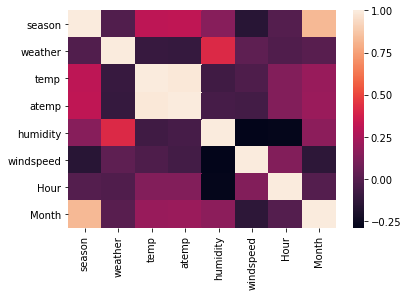

In [16]:
sns.heatmap(sd.corr())

In [17]:
ws_test=ws_impute[ws_impute['windspeed']==0]
ws_impute=ws_impute[ws_impute['windspeed']>0]

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ws_impute.drop(['windspeed','season','weather'],axis=1), ws_impute['windspeed'], test_size=0.1, random_state=42)

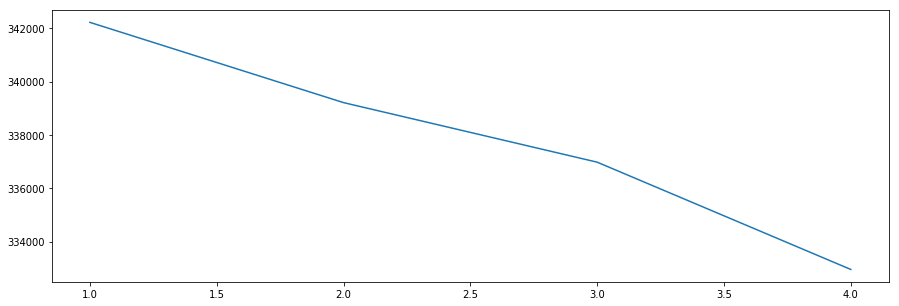

In [19]:
from sklearn.neighbors import KNeighborsRegressor
corr = []
for i in range(1,5):
    knn=KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    corr.append(np.correlate(pred_i,y_test))
plt.figure(figsize=(15,5))
plt.plot(range(1,5),corr)

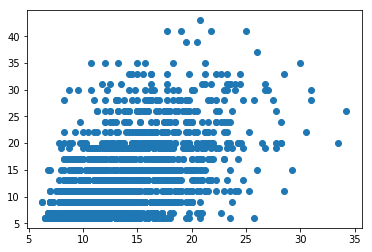

In [20]:
plt.scatter(pred_i,y_test)

wow, so this is a pretty terrible way to predict windspeed values.

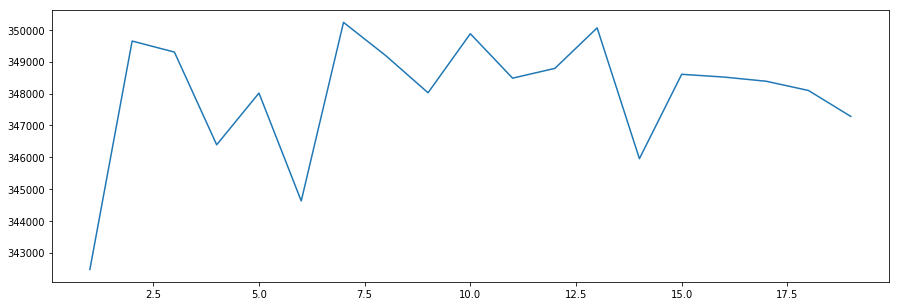

In [21]:
from sklearn.ensemble import RandomForestRegressor
corr = []
for i in range(1,20):
    rfr=RandomForestRegressor(n_estimators=i)
    rfr.fit(X_train,y_train)
    pred_i = rfr.predict(X_test)
    corr.append(np.correlate(pred_i,y_test))
plt.figure(figsize=(15,5))
plt.plot(range(1,20),corr)

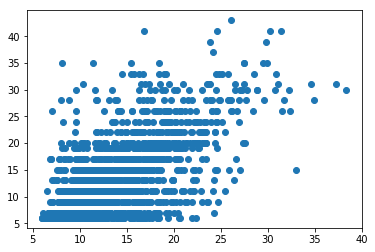

In [22]:
plt.scatter(pred_i,y_test)

In [23]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

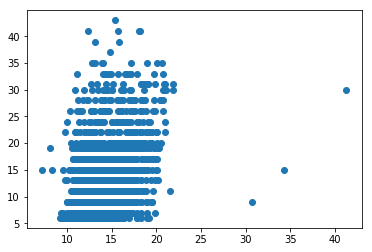

In [24]:
lin.fit(X_train, y_train)
predictions = lin.predict(X_test)
plt.scatter(predictions,y_test)

I don't know. these predictions seem awful. 


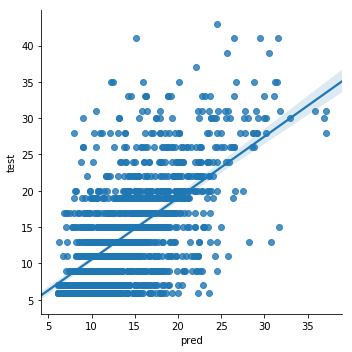

In [25]:
rfr=RandomForestRegressor(n_estimators=15)
rfr.fit(X_train,y_train)
pred_i = rfr.predict(X_test)
plotdata=pd.DataFrame()
plotdata['test']=y_test
plotdata['pred']=pred_i
sns.lmplot('pred','test',plotdata)

In [26]:
ws_test.head()

,season,weather,temp,atemp,humidity,windspeed,Hour,Month
datetime,,,,,,,,
2011-01-01 00:00:00,1,1,9.84,14.395,81,0.0,0,1
2011-01-01 01:00:00,1,1,9.02,13.635,80,0.0,1,1
2011-01-01 02:00:00,1,1,9.02,13.635,80,0.0,2,1
2011-01-01 03:00:00,1,1,9.84,14.395,75,0.0,3,1
2011-01-01 04:00:00,1,1,9.84,14.395,75,0.0,4,1


# moving on without any fancy imputation:

After all of that and what I've read other people doing, the thing that makes the most sense to me is to just fill the zeros in the windspeed and humidity with the value in the previous hour. It's not like there is never zero wind, it just looks like the wind is quite noisy and that the zero values might not be real. 

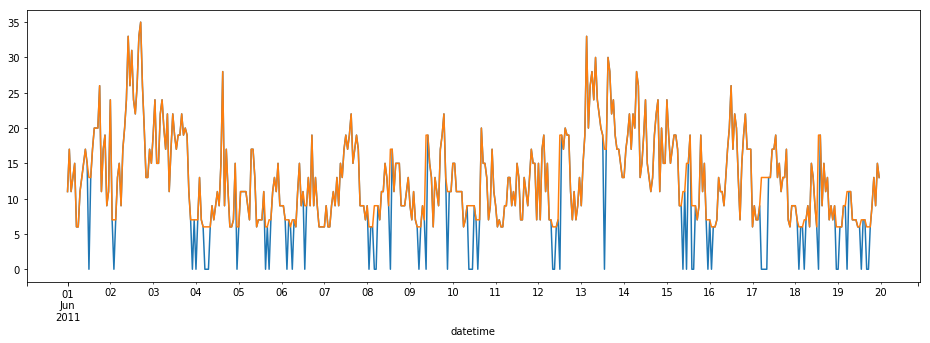

In [27]:
plt.figure(figsize=(16,5))
data['windspeed']['2011-06'].plot()
windfill = data['windspeed'].replace(to_replace=0,method='bfill')
data['windfill']=windfill
data['windfill']['2011-06'].plot()

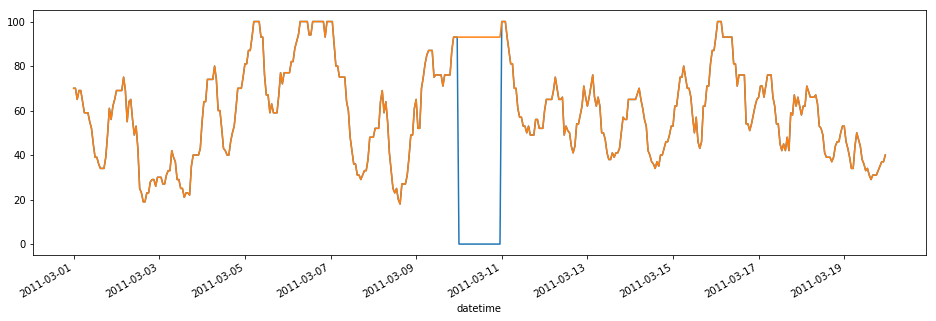

In [28]:
plt.figure(figsize=(16,5))
data['humidity']['2011-03'].plot()
humidfill = data['humidity'].replace(to_replace=0,method='ffill')
data['humidfill']=humidfill
data['humidfill']['2011-03'].plot()

ok, so what's going on now with our data:

In [29]:
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Hour,Month,day of week,reg_adj,cas_adj,reg_trend,cas_trend,windfill,humidfill
datetime,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,5,0.042529,0.156826,305.676420,19.129464,6.0032,81
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,5,0.104675,0.418162,305.707735,19.131334,6.0032,80
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,5,0.088311,0.261326,305.739050,19.133205,6.0032,80
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,5,0.032704,0.156780,305.770365,19.135075,6.0032,75
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,5,0.003270,0.000000,305.801680,19.136946,6.0032,75


Since I have already adjusted for the season and trend, I'm going to drop the season column. Now I'm going to make 2 separate data sets for predicting the registered and casual users. 

In [32]:
X_casual_train = pd.DataFrame(data[['season','holiday', 'weather','atemp','Hour','Month','day of week','windfill','humidfill','cas_trend']],index=data.index, columns=['season','holiday', 'weather','atemp','Hour','Month','day of week','windfill','humidfill','cas_trend'])
y_casual_train = pd.DataFrame(data['cas_adj'],index=data.index)
X_casual_train.head()

,season,holiday,weather,atemp,Hour,Month,day of week,windfill,humidfill,cas_trend
datetime,,,,,,,,,,
2011-01-01 00:00:00,1,0,1,14.395,0,1,5,6.0032,81,19.129464
2011-01-01 01:00:00,1,0,1,13.635,1,1,5,6.0032,80,19.131334
2011-01-01 02:00:00,1,0,1,13.635,2,1,5,6.0032,80,19.133205
2011-01-01 03:00:00,1,0,1,14.395,3,1,5,6.0032,75,19.135075
2011-01-01 04:00:00,1,0,1,14.395,4,1,5,6.0032,75,19.136946


In [33]:
from sklearn.model_selection import train_test_split
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X_casual_train, y_casual_train, test_size=0.1, random_state=101)

C:\Users\LSMdell\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\LSMdell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\LSMdell\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after 

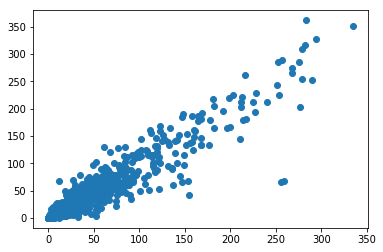

In [41]:
rfr=RandomForestRegressor(n_estimators=15)
rfr.fit(X_trainc.drop('cas_trend',axis=1),y_trainc)
y_testc['pred'] = rfr.predict(X_testc.drop('cas_trend',axis=1))
y_testc['pc']= y_testc['pred']*X_testc['cas_trend']
y_testc['cas'] = y_testc['cas_adj']*X_testc['cas_trend']
plt.scatter(y_testc['pc'],y_testc['cas'])

In [40]:
y_testc.head()

,cas_adj,pred
datetime,,
2012-07-10 13:00:00,1.745507,1.778067
2012-10-07 13:00:00,1.662906,1.959942
2012-01-11 14:00:00,0.083357,0.107119
2012-09-19 21:00:00,0.528368,0.592720
2012-04-02 04:00:00,0.050439,0.064344


In [44]:
rmse = np.sqrt(mean_squared_error(np.log(y_testc['cas']+1),np.log(y_testc['pc']+1)))
print(rmse)

0.5445768921351809


In [45]:
X_registered_train = pd.DataFrame(data[['workingday', 'weather','temp','atemp','Hour','Month','day of week','windfill','humidfill','reg_trend']],index=data.index, columns=['workingday', 'weather','temp','atemp','Hour','Month','day of week','windfill','humidfill','reg_trend'])
y_registered_train = pd.DataFrame(data['reg_adj'],index=data.index)
X_registered_train.head()

,workingday,weather,temp,atemp,Hour,Month,day of week,windfill,humidfill,reg_trend
datetime,,,,,,,,,,
2011-01-01 00:00:00,0,1,9.84,14.395,0,1,5,6.0032,81,305.676420
2011-01-01 01:00:00,0,1,9.02,13.635,1,1,5,6.0032,80,305.707735
2011-01-01 02:00:00,0,1,9.02,13.635,2,1,5,6.0032,80,305.739050
2011-01-01 03:00:00,0,1,9.84,14.395,3,1,5,6.0032,75,305.770365
2011-01-01 04:00:00,0,1,9.84,14.395,4,1,5,6.0032,75,305.801680


In [46]:
from sklearn.model_selection import train_test_split
X_trainr, X_testr, y_trainr, y_testr = train_test_split(X_registered_train, y_registered_train, test_size=0.1, random_state=101)

C:\Users\LSMdell\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\LSMdell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\LSMdell\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after 

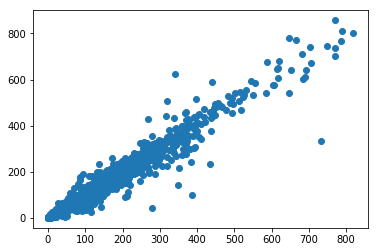

In [47]:
rfr=RandomForestRegressor(n_estimators=15)
rfr.fit(X_trainr.drop('reg_trend',axis=1),y_trainr)
y_testr['pred'] = rfr.predict(X_testr.drop('reg_trend',axis=1))
y_testr['pr']= y_testr['pred']*X_testr['reg_trend']
y_testr['reg'] = y_testr['reg_adj']*X_testr['reg_trend']
plt.scatter(y_testr['pr'],y_testr['reg'])

In [43]:
from sklearn.metrics import mean_squared_error

In [48]:
rmse = np.sqrt(mean_squared_error(np.log(y_testr['reg']+1),np.log(y_testr['pr']+1)))
print(rmse)

0.32922120492508766


In [271]:
rmse = np.sqrt(mean_squared_error(np.log(y_testr+1),np.log(pred_r+1)))
print(rmse)

0.04436309344251129


OK. so, I feel convinced that I should use the trend removed data but include the season information and then just multiply back by the trend. Let's do that. 

In [280]:
y_test_total = y_testc['cas_adj']+y_testr['reg_adj']
print(y_test_total.head())
pred_total = pred_r+pred_c
#print(pred_total.head())

datetime
2012-07-10 13:00:00    2.025913
2012-10-07 13:00:00    1.966381
2012-01-11 14:00:00    0.202415
2012-09-19 21:00:00    0.945055
2012-04-02 04:00:00    0.053519
dtype: float64


In [281]:
rmse = np.sqrt(mean_squared_error(np.log(y_test_total+1),np.log(pred_total+1)))
print(rmse)

0.1670415686512292


In [218]:
rmse = np.sqrt(mean_squared_error(np.log(y_testc+1),np.log(pred_c+1)))
print(rmse)

0.5651415162309826


now get test datetime and fit trend to multiply back 

In [284]:
tc = data_cas
tr = data_reg
x_train = mdates.date2num(tc.index)
zc = np.polyfit(x_train,y=tc['trend'],deg=1) #fit a 1 degree polynomial to the trend time
pc = np.poly1d(zc)
zr = np.polyfit(x_train,y=tr['trend'],deg=1) #fit a 1 degree polynomial to the trend time
pr = np.poly1d(zr)


                     season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

                     humidity  windspeed     ctrend      rtrend  
datetime                                                         
2011-01-20 00:00:00        56    26.0027  19.982395  319.956058  
2011-01-20 01:00:00        56     0.0000  19.984266  319.987373  
2011-01-20 02:00:00        56     0.0000  19.986136  320.018688  
2011-01-20 03:00:00        56    11.0014  19.988007  320.050003  
2011-01-20 04:00:00        56    11.0014  19.989877  320.081318  


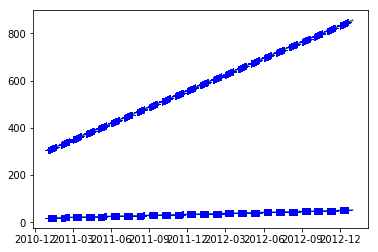

In [286]:
xx = mdates.date2num(data_test.index)
dd = mdates.num2date(xx)

plt.plot(dd, pc(xx), '-g')
plt.plot(x_train, tc['trend'], '+', color='b', label='blub')
data_test['ctrend'] = pc(xx)
plt.plot(dd, pr(xx), '-g')
plt.plot(x_train, tr['trend'], '+', color='b', label='blub')
data_test['rtrend'] = pr(xx)
print(data_test.head())


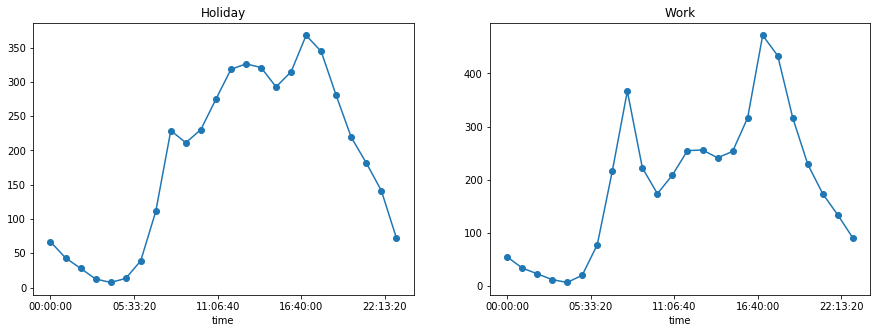

In [13]:
h = np.where(data['holiday'] ==1, 'Holiday', 'Work')
by_time = data['count'].groupby([h, data.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
by_time.loc['Holiday'].plot(ax=ax[0], title='Holiday',marker='o')
by_time.loc['Work'].plot(ax=ax[1], title='Work',marker='o')

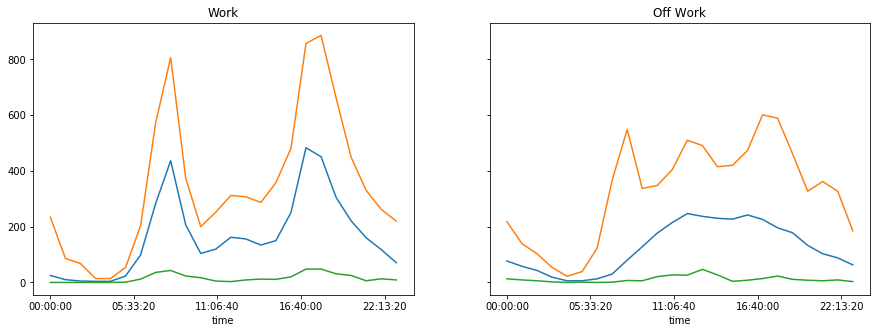

In [26]:
w = np.where(data['workingday'] ==1, 'work', 'off work')
by_time_mean = data['registered'].groupby([w, data.index.time]).median()
by_time_max =data['registered'].groupby([w, data.index.time]).max()
by_time_min = data['registered'].groupby([w, data.index.time]).min()
fig, ax = plt.subplots(1, 2, figsize=(15, 5),sharey=True)
#plt.ylim([0,1])
by_time_mean.loc['work'].plot(ax=ax[0], title='Work')
by_time_max.loc['work'].plot(ax=ax[0], title='Work')
by_time_min.loc['work'].plot(ax=ax[0], title='Work')

by_time_mean.loc['off work'].plot(ax=ax[1], title='Off Work')
by_time_max.loc['off work'].plot(ax=ax[1], title='Off Work')
by_time_min.loc['off work'].plot(ax=ax[1], title='Off Work')

C:\Users\LSMdell\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


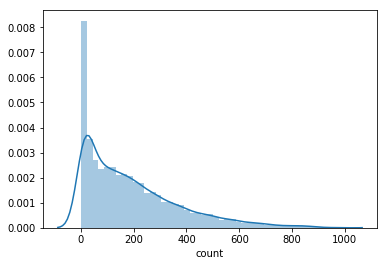

In [80]:
 sns.distplot(data['count'])

C:\Users\LSMdell\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


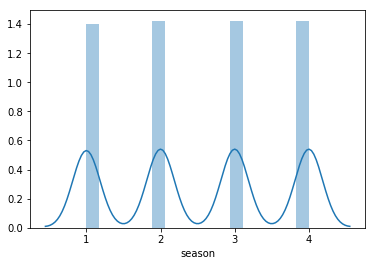

In [6]:
 sns.distplot(data['season'])

C:\Users\LSMdell\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


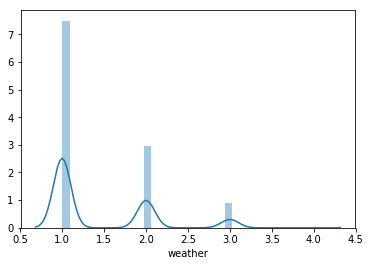

In [7]:
 sns.distplot(data['weather'])

In [ ]:
 sns.distplot(data['count'])

this data looks bimodal to me. let's see if we can separate the working days from the non-working days and see if it helps

C:\Users\LSMdell\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


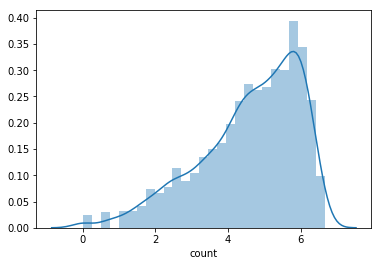

In [88]:
off_data = data[data['workingday']==0]
on_data = data[data['workingday']==1]
sns.distplot(np.log(off_data['count']))
#sns.distplot(on_data['count'])

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['count','casual','registered'],axis=1), data['count'], test_size=0.33, random_state=101)

In [37]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
# The coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [-7.05253612  5.33282004  5.57144509 -0.07094449  2.44314423  4.28524476
 -2.36533903  0.24209554  7.68927973 10.102124    1.60479063]


Text(0,0.5,'Predicted Y')

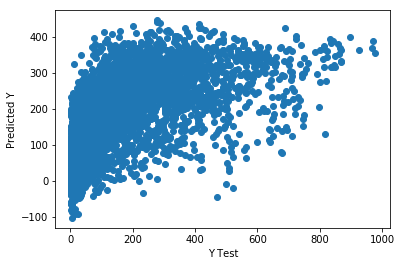

In [38]:
predictions = lm.predict( X_test)
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [39]:
# calculate these metrics by hand!
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

MAE: 108.02972067275213
MSE: 21345.361140703248
RMSE: 146.10051724995105


C:\Users\LSMdell\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


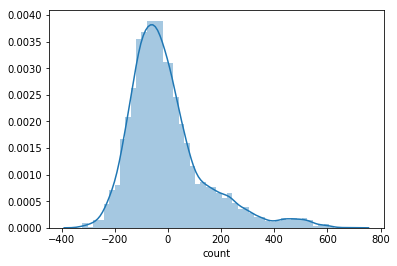

In [40]:
sns.distplot((y_test-predictions),bins=50);

In [41]:
coeffecients = pd.DataFrame(lm.coef_,data.drop(['count','casual','registered'],axis=1).columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
season,-7.052536
holiday,5.332820
workingday,5.571445
weather,-0.070944
temp,2.443144
atemp,4.285245
humidity,-2.365339
windspeed,0.242096
Hour,7.689280
Month,10.102124


In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[data['day of week']==5].drop(['count','casual','registered','day of week'],axis=1), data[data['day of week']==5]['count'], test_size=0.33, random_state=101)

well that result is not so great. Let's try to break the data up into sub-units. 


Coefficients: 
 [-3.32024690e+01  6.75015599e-14 -5.86197757e-14  2.79950161e+01
 -7.14827729e+00  1.48303660e+01 -3.92917663e+00 -7.19283171e-01
  5.95244003e+00  1.71712320e+01]


Text(0,0.5,'Predicted Y')

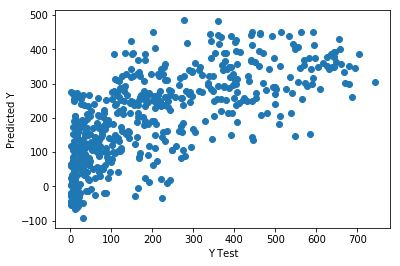

In [60]:
lm = LinearRegression()
lm.fit(X_train,y_train)
# The coefficients
print('Coefficients: \n', lm.coef_)
predictions = lm.predict( X_test)
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [62]:
# calculate these metrics by hand!
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

MAE: 109.42033065540231
MSE: 19596.689411528387
RMSE: 139.98817597043112


In [64]:
coeffecients = pd.DataFrame(lm.coef_,data.drop(['count','casual','registered','day of week'],axis=1).columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
season,-3.320247e+01
holiday,6.750156e-14
workingday,-5.861978e-14
weather,2.799502e+01
temp,-7.148277e+00
atemp,1.483037e+01
humidity,-3.929177e+00
windspeed,-7.192832e-01
Hour,5.952440e+00
Month,1.717123e+01


In [50]:
by_weekday = data.groupby('day of week', axis=1)

In [52]:
by_weekday

Let's go retrieve the csv files I made from the longitudinal analysis:

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
data_reg = pd.read_csv('registered_stationary.csv', parse_dates=['datetime'], index_col='datetime',date_parser=dateparse)
data_cas = pd.read_csv('casual_stationary.csv', parse_dates=['datetime'], index_col='datetime',date_parser=dateparse)

print(data_reg.info())
print(data_cas.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 4 columns):
data        10886 non-null int64
trend       10886 non-null float64
seasonal    10886 non-null float64
residual    10886 non-null float64
dtypes: float64(3), int64(1)
memory usage: 425.2 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 4 columns):
data        10886 non-null int64
trend       10886 non-null float64
seasonal    10886 non-null float64
residual    10886 non-null float64
dtypes: float64(3), int64(1)
memory usage: 425.2 KB
None
